In [78]:
import pandas as pd 

data = pd.read_csv("data/2019-09-27-basel-measures.csv", delimiter=";")
data = data.iloc[:,0:17] 
data["date"] = pd.to_datetime(data["date"])

## Show time-series of singel data point

In [79]:
selected = data["osm_id"]==2621172927
dataSinglePoint = data[selected]

print(dataSinglePoint.head())

     collection  suitcase_id     place_name place_type      osm_id cci_id  \
3        places           49  Leimgrubenweg   bus_stop  2621172927    287   
182      places           49  Leimgrubenweg   bus_stop  2621172927    287   
188      places           49  Leimgrubenweg   bus_stop  2621172927    287   
540      places           49  Leimgrubenweg   bus_stop  2621172927    287   
1193     places           49  Leimgrubenweg   bus_stop  2621172927    287   

                    date       cci  rateCigarrettes  ratePapers  rateBottles  \
3    2019-04-01 08:40:57  3.197570         0.600000    1.200000          0.0   
182  2019-04-01 10:37:48  3.354403         0.442360    1.200000          0.0   
188  2019-04-01 13:41:49  3.504265         0.442360    1.052586          0.0   
540  2019-04-02 12:32:50  3.938761         0.411573    0.648391          0.0   
1193 2019-04-05 12:41:36  4.995851         0.000000    0.000000          0.0   

      rateExcrements  rateSyringues  rateGums  rateLeave

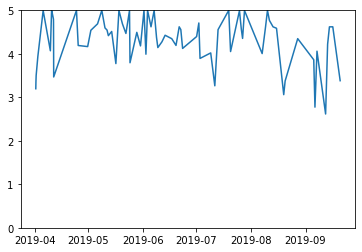

In [80]:
import numpy as np
import matplotlib.pyplot as plt

x = dataSinglePoint["date"].values
y = dataSinglePoint["cci"].values

plt.plot(x, y)
axes = plt.gca().set_ylim([0, 5])
plt.show()

## Remove places scanned less then 10

In [81]:
data["key"] = data["osm_id"].map(str) + "-" + data["cci_id"].map(str)

count = data["key"].value_counts() > 10
trueKeys = count[count]
cleanData = data[data["key"].isin(trueKeys.index)]

print("before: " + str(data.shape))
print("after: " + str(cleanData.shape))

before: (58242, 18)
after: (57834, 18)


## Get average of each place and sort ascending

In [86]:
sortedData = cleanData.sort_values(by=["key"])
averagePerInstance = sortedData[["key", "cci", "rateCigarrettes", "ratePapers", "rateBottles", "rateExcrements", "rateSyringues", "rateGums", "rateLeaves", "rateGrits", "rateGlassDebris"]].groupby("key").mean()
averagePerInstanceSorted = averagePerInstance.sort_values(by="cci")
print(averagePerInstanceSorted.head())

                        cci  rateCigarrettes  ratePapers  rateBottles  \
key                                                                     
12362783-nan       2.636143         0.513658    1.065026     0.707657   
51930236-nan       2.696042         0.476194    0.927359     0.834882   
24511697-nan       2.949671         0.517253    1.008833     0.461128   
26751645-86_10213  3.061218         0.483548    0.935765     0.493871   
4803830-86_17088   3.179701         0.512451    0.878791     0.389890   

                   rateExcrements  rateSyringues  rateGums  rateLeaves  \
key                                                                      
12362783-nan                    0              0         0    0.049446   
51930236-nan                    0              0         0    0.065522   
24511697-nan                    0              0         0    0.049081   
26751645-86_10213               0              0         0    0.025598   
4803830-86_17088                0           

## Show places having a CCI < 3

In [83]:
lowerThreeSelected = averagePerInstance["cci"] < 3
lowerThree = averagePerInstance[lowerThreeSelected]
                                        
print(lowerThree)

                   cci  rateCigarrettes  ratePapers  rateBottles  \
key                                                                
12362783-nan  2.636143         0.513658    1.065026     0.707657   
24511697-nan  2.949671         0.517253    1.008833     0.461128   
51930236-nan  2.696042         0.476194    0.927359     0.834882   

              rateExcrements  rateSyringues  rateGums  rateLeaves  rateGrits  \
key                                                                            
12362783-nan               0              0         0    0.049446          0   
24511697-nan               0              0         0    0.049081          0   
51930236-nan               0              0         0    0.065522          0   

              rateGlassDebris  
key                            
12362783-nan         0.028070  
24511697-nan         0.014035  
51930236-nan         0.000000  


## Heatmap

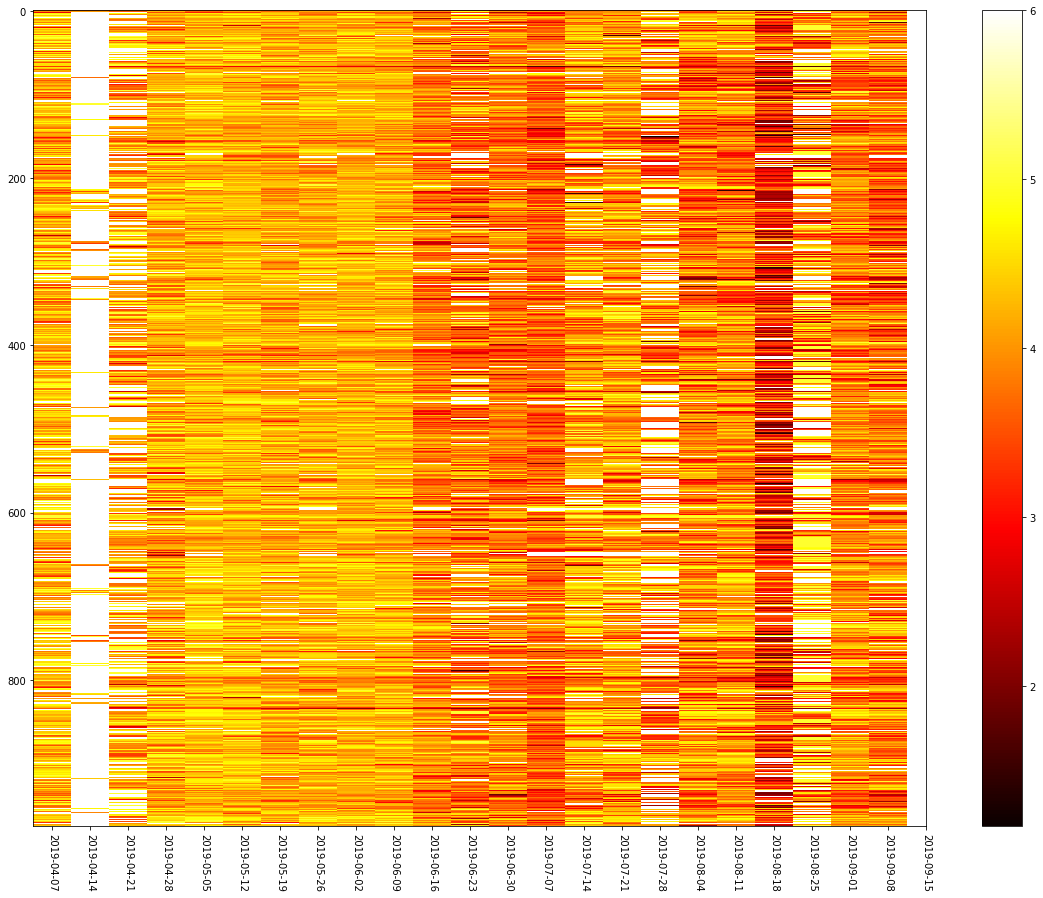

2019-04-07 08:40:49
2019-07-21 08:40:49


In [174]:
oldestDate = sortedData["date"].min()
newestDate = sortedData["date"].max()

dateRange = pd.date_range(start=str(oldestDate), end=str(newestDate), freq='W-SUN').to_pydatetime().tolist()
#dateRange = pd.date_range(start=str(oldestDate), end=str(newestDate), freq='3D').to_pydatetime().tolist()
allKeys = sortedData["key"].unique()
allKeys = pd.DataFrame(index=allKeys, columns=["cci", "date"])

finalData = pd.DataFrame()
cciData = sortedData[["key", "cci", "date"]]
for i in range(0, len(dateRange)-1):
    temp = cciData
    selectedLower = temp["date"] >= dateRange[i] 
    tempLowerFilter = temp[selectedLower]
    selectedUpper = tempLowerFilter["date"] < dateRange[i+1]
    tempBothFilter = tempLowerFilter[selectedUpper]
    
    rangeData = allKeys
    rangeData["cci"] = -1
    rangeData["date"] = dateRange[i]
    
    meanData = tempBothFilter[["key", "cci"]].groupby("key").mean()
    rangeData.loc[:, "cci"] = meanData["cci"]
    rangeData.fillna(6, inplace=True)
    
    columnName = "cci" + str(i)
    finalData[columnName] = rangeData["cci"]


plt.figure(figsize = (20,15))
im = plt.imshow(finalData.values, cmap='hot', interpolation='nearest', aspect='auto')

ax = plt.gca()
dates = pd.DataFrame(dateRange, columns=["date"])
plt.xticks(dates["date"].dt.strftime('%Y-%m-%d').index, dates["date"].dt.strftime('%Y-%m-%d'), rotation=-90)

plt.colorbar(im);
plt.show()

print(dateRange[0])
print(dateRange[15])